In [2]:
#setup
from mlwpy import *
diabetes = datasets.load_diabetes()
%matplotlib inline
sns.__version__

'0.9.0'

### 5.3.1 Synthetic Data and Linear Regression

In [3]:
N = 20
ftr = np.linspace(-10, 10, num=N)                  #ftr vals
tgt = 2*ftr**2 -3 + np.random.uniform(-2, 2, N)    #tgt = func(ftr)

(train_ftr, test_ftr,
train_tgt, test_tgt) = skms.train_test_split(ftr,
                                            tgt,
                                            test_size=N//2)

display(pd.DataFrame({"ftr":train_ftr,
                     "tgt":train_tgt}).T)

,0,1,2,3,4,5,6,7,8,9
ftr,-1.5789,-6.8421,-3.6842,1.5789,-7.8947,3.6842,7.8947,4.7368,5.7895,-0.5263
tgt,2.3906,91.0234,22.3791,3.8658,122.5817,22.9962,121.7528,40.6026,62.7696,-1.6137


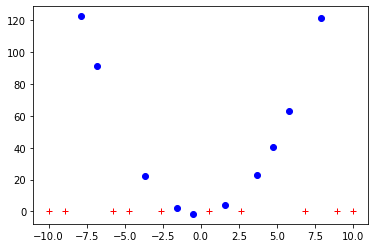

In [4]:
plt.plot(train_ftr, train_tgt, 'bo')
plt.plot(test_ftr, np.zeros_like(test_ftr), 'r+');

In [5]:
#note: sklearn *really* wants 2D inputs (a table)
#so we use reshape here
sk_model = linear_model.LinearRegression()
sk_model.fit(train_ftr.reshape(-1,1), train_tgt)
sk_preds = sk_model.predict(test_ftr.reshape(-1,1))
sk_preds[:3]

array([53.218 , 41.4552, 56.8374])

In [6]:
#fit-predict-evaluate a 1D polynomial (a line)
model_one = np.poly1d(np.polyfit(train_ftr, train_tgt, 1))
preds_one = model_one(test_ftr)
print(preds_one[:3])

[53.218  41.4552 56.8374]


In [7]:
#the predictions come back the same
print("all close?", np.allclose(sk_preds, preds_one))

#and we can still use sklearn to evaluate it
mse = metrics.mean_squared_error
print("RMSE:", np.sqrt(mse(test_tgt, preds_one)))

all close? True
RMSE: 86.69151817350722


In [8]:
#fit-predict-evaluate a 2D polynomial (a parabola)
model_two = np.poly1d(np.polyfit(train_ftr, train_tgt, 2))
preds_two = model_two(test_ftr)
print("RMSE:", np.sqrt(mse(test_tgt, preds_two)))

RMSE: 1.2765992188881117


In [9]:
model_three = np.poly1d(np.polyfit(train_ftr, train_tgt, 9))
preds_three = model_three(test_ftr)
print("RSME:", np.sqrt(mse(test_tgt, preds_three)))

RSME: 317.3634424235501


### 5.3.3 Visualizing Over-Underfitting and "Just Right"

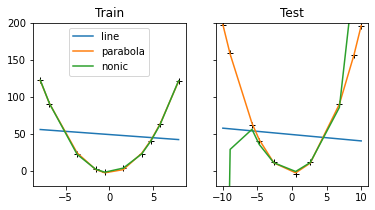

In [11]:
fig, axes = plt.subplots(1,2,figsize=(6,3),sharey=True)

labels = ['line','parabola','nonic']
models = [model_one, model_two, model_three]
train = (train_ftr, train_tgt)
test = (test_ftr, test_tgt)

for ax, (ftr,tgt) in zip(axes, [train, test]):
    ax.plot(ftr, tgt, 'k+')
    
    for m,lbl in zip(models, labels):
        ftr = sorted(ftr)
        ax.plot(ftr, m(ftr), '-', label=lbl)
        
axes[1].set_ylim(-20, 200)
axes[0].set_title("Train")
axes[1].set_title("Test");
axes[0].legend(loc='upper center');

In [12]:
results = []

for complexity in [1, 2, 6, 9]:
    model = np.poly1d(np.polyfit(train_ftr, train_tgt, complexity))
    train_error = np.sqrt(mse(train_tgt, model(train_ftr)))
    test_error = np.sqrt(mse(test_tgt, model(test_ftr)))
    results.append((complexity, train_error, test_error))
    
columns = ["Complexity", "Train Error", "Test Error"]
results_df = pd.DataFrame.from_records(results, 
                                      columns=columns,
                                      index="Complexity")

results_df

,Train Error,Test Error
Complexity,,
1,45.4951,86.6915
2,1.0828,1.2766
6,0.2819,6.1417
9,0.0000,317.3634


<AxesSubplot:xlabel='Complexity'>

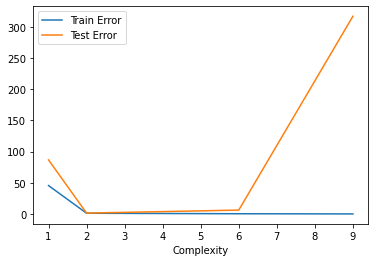

In [13]:
results_df.plot()

In [23]:
def training_loss(loss, model, training_data):
    ' total training_loss on train_data with model under loss '
    return sum(loss(model.predict(x.reshape(1, -1)), y)
              for x, y in training_data)

def squared_error(prediction, actual):
    ' squared error on a single example '
    return (prediction - actual)**2

#could be used like:
#my_training_loss = training_loss(squared_error, model, training_data)

In [24]:
knn = neighbors.KNeighborsRegressor(n_neighbors=3)
fit = knn.fit(diabetes.data, diabetes.target)

training_data = zip(diabetes.data, diabetes.target)

my_training_loss = training_loss(squared_error,
                                knn,
                                training_data)

print(my_training_loss)

[863792.3333]


In [27]:
mse = metrics.mean_squared_error(diabetes.target,
                                knn.predict(diabetes.data))

print(mse*len(diabetes.data))

863792.3333333333


In [28]:
def complexity(model):
    return model.complexity

def cost(model, training_data, loss, _lambda):
    return training_loss(m,D) + _lambda * complexity(m)

In [29]:
#data, model, fit & cv-score
model = neighbors.KNeighborsRegressor(10)
skms.cross_val_score(model,
                    diabetes.data,
                    diabetes.target,
                    cv=5,
                    scoring='neg_mean_squared_error')

#notes
#defaults for cross_val_score are
#cv=3 fold, no shuffle, stratified if classifier
#model.score by default (regressors: r2, classifiers: accuracy)

array([-3206.7542, -3426.4313, -3587.9422, -3039.4944, -3282.6016])

### 5.5.2 Stratification

In [30]:
iris = datasets.load_iris()
model = neighbors.KNeighborsClassifier(10)
skms.cross_val_score(model, iris.data, iris.target, cv=5)

array([0.9667, 1.    , 1.    , 0.9333, 1.    ])

In [31]:
#not stratified
pet = np.array(['catto', 'doge', 'catto',
               'doge', 'doge', 'doge'])
list_folds = list(skms.KFold(2).split(pet))
training_idxs = np.array(list_folds)[:, 0, :]

print(pet[training_idxs])

[['doge' 'doge' 'doge']
 ['catto' 'doge' 'catto']]


In [32]:
#stratified
#typically behind the scenes
#making StratifiedKFold produce readable output
#is tricky
pet = np.array(['catto', 'doge', 'catto',
               'doge', 'doge', 'doge'])

idxs = np.array(list(skms.StratifiedKFold(2)
                    .split(np.ones_like(pet), pet)))

training_idxs = idxs[:, 0, :]
print(pet[training_idxs])

[['catto' 'doge' 'doge']
 ['catto' 'doge' 'doge']]


In [33]:
#running nonstratified CV
iris = datasets.load_iris()
model = neighbors.KNeighborsClassifier(10)
non_strat_kf = skms.KFold(5)
skms.cross_val_score(model, iris.data,
                    iris.target,
                    cv=non_strat_kf)

array([1.    , 1.    , 0.8667, 0.9667, 0.7667])

### 5.5.3 Repeated Train-Test Splits

In [34]:
linreg = linear_model.LinearRegression()
diabetes = datasets.load_diabetes()

scores = []

for r in range(10):
    tts = skms.train_test_split(diabetes.data,
                               diabetes.target,
                               test_size=.25)
    
    (diabetes_train_ftrs, diabetes_test_ftrs,
    diabetes_train_tgt, diabetes_test_tgt) = tts
    
    fit = linreg.fit(diabetes_train_ftrs, diabetes_train_tgt)
    preds = fit.predict(diabetes_test_ftrs)
    
    score = metrics.mean_squared_error(diabetes_test_tgt, preds)
    scores.append(score)
    
scores = pd.Series(np.sqrt(sorted(scores)))
df = pd.DataFrame({"RMSE":scores})
df.index.name = 'Repeat'
display(df.T)

Repeat,0,1,2,3,4,5,6,7,8,9
RMSE,49.0032,50.1912,51.9735,52.0722,53.2005,55.7008,56.2542,57.4917,58.6379,58.6942


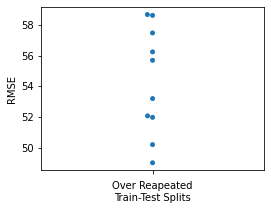

In [35]:
ax = plt.figure(figsize=(4,3)).gca()
sns.swarmplot(y='RMSE', data=df, ax=ax)
ax.set_xlabel('Over Reapeated\nTrain-Test Splits');

In [36]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
RMSE,10.0000,54.3219,3.5058,49.0032,51.9982,54.4507,57.1823,58.6942


In [37]:
def tts_fit_score(model, data, msr, test_size=.25):
    ' apply a train-test split to fit model on data and eval with MSR '
    tts = skms.train_test_split(data.data,
                               data.target,
                               test_size=test_size)
    
    (train_ftrs, test_ftrs, train_tgt, test_tgt) = tts
    
    fit = linreg.fit(train_ftrs, train_tgt)
    preds = fit.predict(test_ftrs)
    
    score = msr(test_tgt, preds)
    return score

linreg = linear_model.LinearRegression()
diabetes = datasets.load_diabetes()
scores = [tts_fit_score(linreg, diabetes,
                       metrics.mean_squared_error) for i in range(10)]

print(np.mean(scores))

3052.540273057884


### 5.5.4 Shuffling

,count,mean,std,min,25%,50%,75%,max
RMSE,10.0000,55.4388,3.5870,50.1900,52.9660,55.3967,58.3911,60.5432


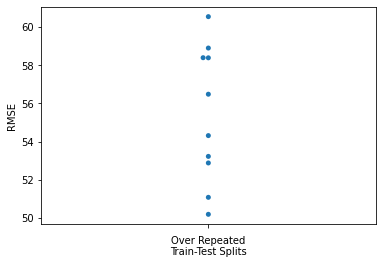

In [38]:
linreg = linear_model.LinearRegression()
diabetes = datasets.load_diabetes()

#nondefault cv= argument
ss = skms.ShuffleSplit(test_size=.25) # default, 10 splits
scores = skms.cross_val_score(linreg, diabetes.data, diabetes.target,
                             cv=ss,
                             scoring='neg_mean_squared_error')

scores = pd.Series(np.sqrt(-scores))
df = pd.DataFrame({'RMSE':scores})
df.index.name = 'Repeat'

display(df.describe().T)

ax = sns.swarmplot(y='RMSE', data=df)
ax.set_xlabel('Over Repeated\nTrain-Test Splits');

In [39]:
ss = skms.ShuffleSplit(test_size=.25, random_state=42)

train, test = 0, 1
next(ss.split(diabetes.data))[train][:10]

array([ 16, 408, 432, 316,   3,  18, 355,  60, 398, 124])

In [43]:
ss = skms.ShuffleSplit(test_size=.25, random_state=55)
next(ss.split(diabetes.data))[train][:10]

array([ 41, 348, 313,  70,  87, 369, 379, 119, 363, 286])

In [44]:
train, test = 0, 1
kf = skms.KFold(5)
next(kf.split(diabetes.data))[train][:10]

array([89, 90, 91, 92, 93, 94, 95, 96, 97, 98])

In [45]:
kf = skms.KFold(5)
next(kf.split(diabetes.data))[train][:10]

array([89, 90, 91, 92, 93, 94, 95, 96, 97, 98])

In [46]:
pet

array(['catto', 'doge', 'catto', 'doge', 'doge', 'doge'], dtype='<U5')

In [47]:
kf = skms.KFold(3, shuffle=True)

train, test = 0, 1
split_1_group_1 = next(kf.split(pet))[train]
split_2_group_1 = next(kf.split(pet))[train]

print(split_1_group_1,
     split_2_group_1)

[0 1 4 5] [0 1 3 5]


In [48]:
kf = skms.KFold(3, shuffle=True, random_state=42)

train, test = 0, 1
split_1_group_1 = next(kf.split(pet))[train]
split_2_group_1 = next(kf.split(pet))[train]

print(split_1_group_1,
     split_2_group_1)

[2 3 4 5] [2 3 4 5]


### 5.5.5 Leave-One-Out Cross-Validation

,count,mean,std,min,25%,50%,75%,max
RMSE,442.0000,44.3557,32.1973,0.2075,18.4820,39.5472,63.9738,158.2355


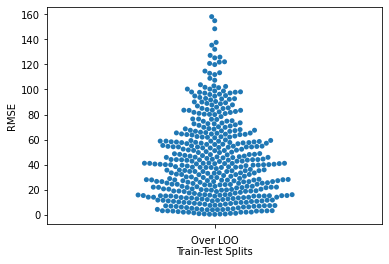

In [49]:
loo = skms.LeaveOneOut()
scores = skms.cross_val_score(linreg,
                             diabetes.data, diabetes.target,
                             cv=loo,
                             scoring='neg_mean_squared_error')

scores = pd.Series(np.sqrt(-scores))
df = pd.DataFrame({'RMSE':scores})
df.index.name = 'Repeat'

display(df.describe().T)

ax = sns.swarmplot(y='RMSE', data=df)
ax.set_xlabel('Over LOO\nTrain-Test Splits');

### 5.7.1 Learning Curves

In [11]:
iris = datasets.load_iris()

#10 data set sizes: 10% - 100%
#(that much data is piped to a 5-fold cross-validation)

train_sizes = np.linspace(.1, 1.0, 10)
nn = neighbors.KNeighborsClassifier()

(train_N,
train_scores,
test_scores) = skms.learning_curve(nn, iris.data, iris.target,
                                  cv=5, train_sizes=train_sizes)

#collapse across the 5 CV scores: one result for each data set size
df = pd.DataFrame(test_scores, index=(train_sizes*100).astype(np.int))
df['Mean 5-CV'] = df.mean(axis='columns')
df.index.name = '% Data Used'

display(df)


,0,1,2,3,4,Mean 5-CV
% Data Used,,,,,,
10,0.3333,0.3333,0.3333,0.3333,0.3333,0.3333
20,0.3333,0.3333,0.3333,0.3333,0.3333,0.3333
30,0.3333,0.3333,0.3333,0.3333,0.3333,0.3333
40,0.6667,0.6667,0.6667,0.6667,0.6667,0.6667
50,0.6667,0.6667,0.6667,0.6667,0.6667,0.6667
60,0.6667,0.6667,0.6667,0.6667,0.6667,0.6667
70,0.9000,0.8000,0.8333,0.8667,0.8000,0.8400
80,0.9667,0.9333,0.9000,0.9000,0.9667,0.9333
90,0.9667,1.0000,0.9000,0.9667,1.0000,0.9667


In [15]:
print(len(train_sizes))
print(len(train_scores))
print(len(test_scores))

10
10
10


In [13]:
joined = np.array([train_scores, test_scores]).transpose()
len(joined)

5

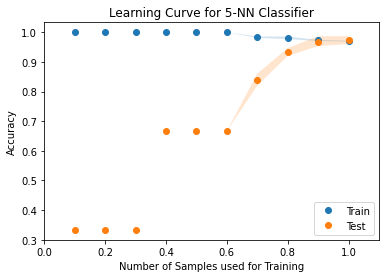

In [14]:
#tsplot (deprecated) expects array data to have these dimensions
# (repeats, times, conditions)
#for us these translate to:
# (CV scores, percents, train/test)

joined = np.array([train_scores, test_scores]).transpose()

ax = sns.tsplot(joined,
               time=train_sizes,
               condition=['Train', 'Test'],
               interpolate=False)


ax.set_title("Learning Curve for 5-NN Classifier")
ax.set_xlabel("Number of Samples used for Training")
ax.set_ylabel("Accuracy");

### 5.7.2 Complexity Curves

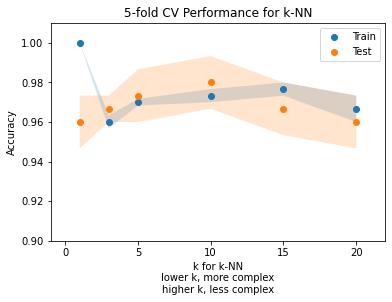

In [17]:
num_neigh = [1, 3, 5, 10, 15, 20]
KNC = neighbors.KNeighborsClassifier
tt = skms.validation_curve(KNC(),
                          iris.data, iris.target,
                          param_name='n_neighbors',
                          param_range=num_neigh,
                          cv=5)

#stack and transpose trick (as above)
ax = sns.tsplot(np.array(tt).transpose(),
               time=num_neigh,
               condition=['Train', 'Test'],
               interpolate=False)

ax.set_title('5-fold CV Performance for k-NN')
ax.set_xlabel("\n".join(['k for k-NN',
                        'lower k, more complex',
                        'higher k, less complex']))
ax.set_ylim(.9,1.01)
ax.set_ylabel('Accuracy');

### 5.8 Comparing Learners with Cross-Validation

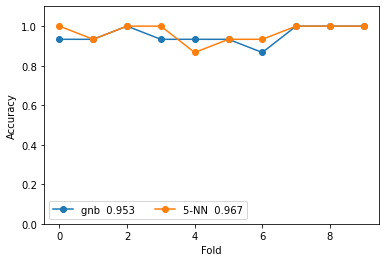

In [19]:
classifiers = {'gnb': naive_bayes.GaussianNB(),
              '5-NN': neighbors.KNeighborsClassifier(n_neighbors=5)}

iris = datasets.load_iris()

fig, ax = plt.subplots(figsize=(6,4))
for name, model in classifiers.items():
    cv_scores = skms.cross_val_score(model,
                                    iris.data,iris.target,
                                    cv=10,
                                    scoring='accuracy',
                                    n_jobs=-1) # use all cores
    my_lbl = "{}  {:.3f}".format(name, cv_scores.mean())
    ax.plot(cv_scores, '-o', label=my_lbl)
ax.set_ylim(0.0, 1.1)
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.legend(ncol=2);